<center>
<img src="logo.png" height="900"> 
</center>


#  Что разрешает ЗБЧ


---------------

In [1]:
import pandas as pd
pd.__version__

'2.0.3'

In [2]:
!pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.6 kB ? eta -:--:--
     -------------------------------------- 57.6/57.6 kB 751.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   -------------------- ------------------- 41.0/78.3 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 1.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from scipy import stats

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

# 1. Сложные распределения

ЗБЧ разрешает нам решать реальные проблемы с помощью симуляций. Например, можно оценить математическое ожидание случайной величины $\frac{1}{X}$, где $X \sim N(5; 3)$ без взятия интегралов.

In [4]:
n_obs = 10**6

norm_rv = stats.norm(loc=5, scale=3)  
x = norm_rv.rvs(n_obs)

np.mean(1/x)

0.1501619175905683

Если бы не было питона пришлось бы искать такой интеграл: 

$$
\mathbb{E} \left(\frac{1}{X} \right) = \int_{-\infty}^{+\infty} \frac{1}{x} \cdot \frac{1}{\sigma \sqrt{2 \pi}} \cdot  e^{-\frac{(x - 5)^2}{2 \cdot 3^2}} dx.
$$

> __Важно:__ в видео мы с вами сказали, что для данного примера подход с симуляциями не работает. Интеграл расходится, так как этого математического ожидания не существует. При перезапуске симуляций мы каждый раз будем получать в качестве стреднего новые числа. Если мы попробуем нарисовать в динамике, к чему сходится выборочное среднее, мы увидим, что никакой сходимости тут нет. С делением случайных величин надо быть очень осторожным. 

-------------------------

__Другой пример.__ Также легко оценить многие вероятности. Например, оценим вероятность $P(X_1 + X_2 + X_3^2 > 5)$, где величины $X_i$ независимы и одинаково равномерно распределены $X_i \sim U[0;2]$:

In [5]:
n_obs = 10**6

# обратите внимание, что в этой функции задается левая граница и длина
# а не левая и правая границы
uniform_rv = stats.uniform(0, 2)

x_1 = uniform_rv.rvs(n_obs)
x_2 = uniform_rv.rvs(n_obs)
x_3 = uniform_rv.rvs(n_obs)

success = x_1 + x_2 + x_3**2 > 5
success[:5]

array([False,  True,  True, False, False])

In [6]:
np.sum(success) / n_obs

0.147335

Здесь вектор success будет содержать значение `True` там, где условие `x_1 + x_2 + x_3**2 > 5` выполнено, и `False` там, где условие не выполнено. При сложении командой `np.sum()` каждое `True` будет посчитано как единица, а каждое `False` как ноль. Поэтому `np.sum(success)` даст количество раз, когда условие `x_1 + x_2 + x_3**2 > 5` выполнено.

__Как найти такую вероятность руками:__ 

- Первым шагом нам придётся найти распределение для $X_3^2$ 
- Втором шагом по формуле свёртки надо будет найти распределение суммы
- Третьим шагом можно посчитать вероятность

Почти на каждом шаге мы сталкиваемся с интегрированием. 

__Ещё пример.__ давайте найдём условную вероятность $P(X_1 + X_2 + X_3 > 0.8 \mid X_3 < 0.1)$. Снова используем для этого всю мощь `numpy` и сделаем срез по всем объектам, попавшим под условие.

In [7]:
n_obs = 10**6

uniform_rv = stats.uniform(0, 2)

x_1 = uniform_rv.rvs(n_obs)
x_2 = uniform_rv.rvs(n_obs)
x_3 = uniform_rv.rvs(n_obs)

uslovie = x_3 < 0.1

# x[uslovie] оставит в векторе только те элементы, где uslovie == True
success = x_1[uslovie] + x_2[uslovie] + x_3[uslovie] > 0.8
np.sum(success) / np.sum(uslovie)

0.9280607415463316

In [8]:
# можно посмотреть сколько раз за всю симуляцию x_3 < 0.1
np.sum(uslovie)

49653

__Как найти такую вероятность руками:__ 

- Первым шагом по формуле свёртки надо будет найти распределение суммы
- Вторым шагом нам надо будет найти условную плотность 
- Третьим шагом можно посчитать вероятность

__Тем не менее это не говорит про ненужность аналитической работы.__ 

- Постоянно делать симуляции вместо того, чтобы один раз получить формулу и считать по ней - неэффективно 
- Часто возникают ситуации, когда за счёт генераций получить правильный ответ очень сложно. Например, куча проблем возникает для многомерных распределений.

> Подобные численные методы для оценки разных характеристик называются методами Монте-Карло.


# 2. Удав и багеты

Удав Анатолий любит французские багеты. Длина французского багета равна $1$ метру. За один укус Удав Анатолий поедает кусок случайной длины, равномерно распределённый на отрезке $[0;1]$. Для того, чтобы съесть весь багет удаву потребуется случайное количество $N$ укусов. 

Найдём $\mathbb{E}(N)$ и $Var(N)$ с помощью симуляций.

In [9]:
# Багеты! Давайте начнём с одной итерации эксперемента.
unif_rv = stats.uniform(0, 1)

l = 1 # длина багета
m = 0 # число укусов

# пока длина багета больше 0
while l > 0:
    # делай укусы
    l -= unif_rv.rvs(1)
    m += 1 # на один укус стало больше

print(m)

2


Одну итерацию можно обернуть в функцию, чтобы было удобнее пользоваться. 

In [10]:
def eat_one_baguette():
    l = 1
    m = 0 
    while l > 0:
        l -= unif_rv.rvs(1)
        m += 1

    return(m)

eat_one_baguette()

2

Теперь мы можем провести много итераций эксперимента.

In [11]:
n_obs = 10**4 # количество итераций эксперимента
N = [eat_one_baguette() for i in range(n_obs)]

In [12]:
np.mean(N)

2.7249

In [13]:
np.var(N)

0.7614199899999998

Кстати говоря, в сборнике сложных задач по теории вероятностей, [культурном коде,](https://github.com/bdemeshev/probability_dna/raw/master/probability_dna.pdf) можно найти три разных решения этой задаи руками. Она там находится под номером $46$. Кроме неё там много других очень красивых задач. 

# 3. Парадокс дней рождений

__Парадокс дней рождений:__ в произвольной группе из $50$ человек вероятность того, что хотябы у двоих людей дни рождения совпадут, равна $0.97$. Но это в теории, при предпосылке, что люди равномерно рождаются в течение года. Давайте проверим это. 


В табличке `bdates.tsv` лежит информация о $1$ млн. пользователей из вконтакте. В табличке можно найти данные о имени пользователя `first_name`, его поле `sex`, городе проживания `city`, дне `bdate`, месяце `bmonth` и годе `byear` рождения.

In [14]:
df = pd.read_csv("data/vk_bdate.tsv", sep="\t", 
                 dtype={'byear': pd.Int64Dtype(), 
                        'bmonth': pd.Int64Dtype(), 
                         'bday': pd.Int64Dtype()}
                )
print(df.shape)
df.head()

(1000000, 7)


,city,first_name,id,sex,byear,bmonth,bday
0,Севастополь,Галина,268520763,1,1955,2,4
1,Новороссийск,Маша,386703913,1,2002,7,10
2,Нижний Новгород,Екатерина,250291860,1,<NA>,<NA>,<NA>
3,Турсунзаде,Μαχμυδσθδ,384274806,2,<NA>,<NA>,<NA>
4,NaN,Bekzod,366702299,2,<NA>,<NA>,<NA>


Удалим из данных всех, кто не указал когда он родился.

In [15]:
df = df[~(df.bmonth.isnull() | df.bday.isnull())]
df.shape

(694755, 7)

Заведём колонку с днём и месяцем рождения человека.

In [16]:
df['bdate'] = df['bday'].astype(str) + '-' + df['bmonth'].astype(str) 

Построим гистограмму, на которой было бы понятно, в какой месяц родилось какое количество людей. Правда ли, что рождаемость людей в течение года распределена равномерно?

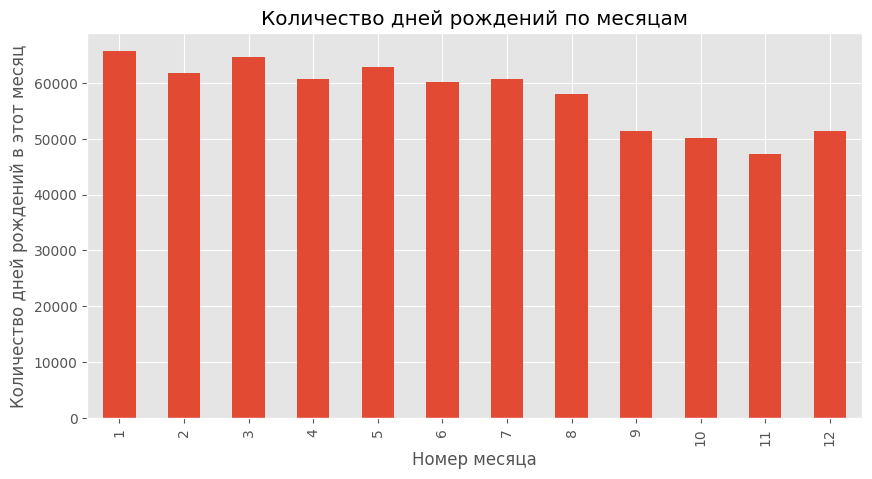

In [17]:
plt.figure(figsize=(10, 5))

df.bmonth.value_counts().sort_index().plot(kind='bar');

plt.title('Количество дней рождений по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Количество дней рождений в этот месяц');

Эмпирически оценим вероятность того, что в группе из 50 произвольных людей найдутся хотя бы двое с одинаковым днём рождения.

In [18]:
df.sample(5) # выборка в 5 человек

,city,first_name,id,sex,byear,bmonth,bday,bdate
758301,Ровно,Тарас,65710906,2,1993,6,7,7-6
525734,Санкт-Петербург,Evgeny,190520749,2,<NA>,5,23,23-5
131911,Полтава,Саша,304873716,2,1989,12,26,26-12
658791,Алматы,Аяулым,301196256,1,1999,4,16,16-4
89768,NaN,Оля,246529769,1,1994,10,11,11-10


In [19]:
# если уникальных дат меньше 50 => совпадение
df.bdate.sample(50).unique().size 

47

In [20]:
n = 10**4  # число симуляций 
m = 0      # счётчик для наших событий

for i in tqdm(range(n)):
    m += df.bdate.sample(50).unique().size < 50

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
m/n # итоговая вероятность 

Похоже на правду. 